### Importing all the required libraries

In [857]:
import numpy as np
import pandas as pd
import itertools
import warnings
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2, f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, classification_report

In [828]:
warnings.filterwarnings(action='ignore')

### Reading the given excel file and getting the sheets it has

In [755]:
excel_file = pd.ExcelFile('Assignment- Membership woes.xlsx')
excel_file.sheet_names  # see all sheet names

['Data', 'Problem statement']

### Read and manipulated the problem statement sheet to get the whole problem statement here

In [756]:
prob_state = pd.read_excel("Assignment- Membership woes.xlsx", sheet_name='Problem statement')
prob_state.head(3)

,Unnamed: 0,Unnamed: 1
0,A certain premium club boasts a large customer...,NaN
1,for using the exclusive facilities offered by ...,NaN
2,"In the last few years, however, the club has b...",NaN


In [757]:
prob_state['Unnamed: 1'].fillna(value = '', inplace=True)
prob_state['Unnamed: 0'].fillna(value = '', inplace=True)
prob_state["prbState"] = prob_state["Unnamed: 1"] + prob_state["Unnamed: 0"]
for i in prob_state['prbState']:
    print(i)

A certain premium club boasts a large customer membership. The members pay an annual membership fee in return 
for using the exclusive facilities offered by this club. The fees are customized for every member's personal package.
In the last few years, however, the club has been facing an issue with a lot of members cancelling their memberships. 
The club management plans to address this issue by proactively addressing customer grievances. They, however, do not have
enough bandwidth to reach out to the entire customer base individually and are looking to see whether a statistical 
approach can help them identify customers at risk. Can you help them ? Relevant data is provided in the worksheet titled "Data".

Instructions:
Please use R to solve this problem and revert with a document which includes the following details:
1) Solution approach and rationale
2) Details of :
a) Data pre-processing
b) The created model
c) Training and test results
3) Relevant R code
4) Anything else that you 

### Reading the 'data' sheet

In [758]:
com_data = pd.read_excel("Assignment- Membership woes.xlsx", sheet_name='Data')
com_data.head(3)

,MEMBERSHIP_NUMBER,MEMBERSHIP_TERM_YEARS,ANNUAL_FEES,MEMBER_MARITAL_STATUS,MEMBER_GENDER,MEMBER_ANNUAL_INCOME,MEMBER_OCCUPATION_CD,MEMBERSHIP_PACKAGE,MEMBER_AGE_AT_ISSUE,ADDITIONAL_MEMBERS,PAYMENT_MODE,AGENT_CODE,MEMBERSHIP_STATUS,START_DATE (YYYYMMDD),END_DATE (YYYYMMDD)
0,A00001,29,113125.0,M,M,25200000.0,1.0,TYPE-B,45,2,ANNUAL,477,INFORCE,20060914,NaN
1,A00002,38,112220.0,M,M,10339200.0,1.0,TYPE-B,36,3,QUARTERLY,255,INFORCE,20061102,NaN
2,A00003,12,100000.0,M,M,14400000.0,1.0,TYPE-B,42,1,ANNUAL,7866,INFORCE,20070124,NaN


### Getting column names

In [759]:
com_data.columns

Index(['MEMBERSHIP_NUMBER', 'MEMBERSHIP_TERM_YEARS', 'ANNUAL_FEES',
       'MEMBER_MARITAL_STATUS', 'MEMBER_GENDER', 'MEMBER_ANNUAL_INCOME',
       'MEMBER_OCCUPATION_CD', 'MEMBERSHIP_PACKAGE', 'MEMBER_AGE_AT_ISSUE',
       'ADDITIONAL_MEMBERS', 'PAYMENT_MODE', 'AGENT_CODE', 'MEMBERSHIP_STATUS',
       'START_DATE (YYYYMMDD)', 'END_DATE  (YYYYMMDD)'],
      dtype='object')

### Description about the data (describe() brings out a lot of information from the dataframe)

In [760]:
com_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10362 entries, 0 to 10361
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MEMBERSHIP_NUMBER      10362 non-null  object 
 1   MEMBERSHIP_TERM_YEARS  10362 non-null  int64  
 2   ANNUAL_FEES            10362 non-null  float64
 3   MEMBER_MARITAL_STATUS  7765 non-null   object 
 4   MEMBER_GENDER          9751 non-null   object 
 5   MEMBER_ANNUAL_INCOME   8608 non-null   float64
 6   MEMBER_OCCUPATION_CD   10319 non-null  float64
 7   MEMBERSHIP_PACKAGE     10362 non-null  object 
 8   MEMBER_AGE_AT_ISSUE    10362 non-null  int64  
 9   ADDITIONAL_MEMBERS     10362 non-null  int64  
 10  PAYMENT_MODE           10362 non-null  object 
 11  AGENT_CODE             10362 non-null  object 
 12  MEMBERSHIP_STATUS      10362 non-null  object 
 13  START_DATE (YYYYMMDD)  10362 non-null  int64  
 14  END_DATE  (YYYYMMDD)   3143 non-null   float64
dtypes:

In [761]:
com_data.describe()

,MEMBERSHIP_TERM_YEARS,ANNUAL_FEES,MEMBER_ANNUAL_INCOME,MEMBER_OCCUPATION_CD,MEMBER_AGE_AT_ISSUE,ADDITIONAL_MEMBERS,START_DATE (YYYYMMDD),END_DATE (YYYYMMDD)
count,10362.000000,1.036200e+04,8.608000e+03,10319.000000,10362.000000,10362.000000,1.036200e+04,3.143000e+03
mean,29.395001,1.788122e+05,1.451100e+06,1.711019,46.798494,1.412276,2.010828e+07,2.011390e+07
std,22.427712,2.688747e+05,1.757174e+07,1.453960,13.897085,1.145136,1.719666e+04,1.378483e+04
min,9.000000,0.000000e+00,9.996000e+03,1.000000,0.000000,0.000000,2.006091e+07,2.007083e+07
25%,12.000000,1.000000e+05,3.999960e+05,1.000000,37.000000,0.000000,2.009123e+07,2.010122e+07
50%,19.000000,1.182093e+05,5.499960e+05,1.000000,46.000000,1.000000,2.010123e+07,2.011113e+07
75%,37.000000,1.900000e+05,9.999960e+05,2.000000,57.000000,2.000000,2.012123e+07,2.013012e+07
max,102.000000,1.010000e+07,1.000000e+09,6.000000,92.000000,3.000000,2.013113e+07,2.013112e+07


### Collecting metadata about the data at hand

In [966]:
print(len(com_data))
print(len(com_data['END_DATE  (YYYYMMDD)'].unique()))
print(len(com_data['START_DATE (YYYYMMDD)'].unique()))
print(com_data['MEMBERSHIP_STATUS'].unique()) 
print() 
print(com_data['MEMBER_GENDER'].unique()) 
print()
print(com_data['PAYMENT_MODE'].unique()) 
print()
print(com_data[com_data['MEMBERSHIP_STATUS']=='INFORCE'].count())

10362
1062
1300
['INFORCE' 'CANCELLED']

['M' nan 'F']

['ANNUAL' 'QUARTERLY' 'MONTHLY' 'SEMI-ANNUAL' 'SINGLE-PREMIUM']

MEMBERSHIP_NUMBER        7219
MEMBERSHIP_TERM_YEARS    7219
ANNUAL_FEES              7219
MEMBER_MARITAL_STATUS    5310
MEMBER_GENDER            6797
MEMBER_ANNUAL_INCOME     5992
MEMBER_OCCUPATION_CD     7184
MEMBERSHIP_PACKAGE       7219
MEMBER_AGE_AT_ISSUE      7219
ADDITIONAL_MEMBERS       7219
PAYMENT_MODE             7219
AGENT_CODE               7219
MEMBERSHIP_STATUS        7219
START_DATE (YYYYMMDD)    7219
END_DATE  (YYYYMMDD)        0
dtype: int64


In [968]:
# Check the proportion of data belonging to each of the classes.
print(com_data['MEMBERSHIP_STATUS'].value_counts(normalize=True)) 

INFORCE      0.69668
CANCELLED    0.30332
Name: MEMBERSHIP_STATUS, dtype: float64


In [763]:
print(com_data['END_DATE  (YYYYMMDD)'].isnull().sum())
print(com_data['START_DATE (YYYYMMDD)'].isnull().sum())
# Number of nan(None/Null) values in the column 'END_DATE' is too much for it to be taken into account

7219
0


In [905]:
# There is a large number of agents that lead the users. There count is 4317 for a whole ~10000 different users. 
# Hence this feature will be of no use in our prediction.
len(onehot_req_com_data['AGENT_CODE'].unique())

4317

In [906]:
# The membership number of a particular user won't we of any use in predicting he's cancelling the subscription or not.
# And then we have already seen that their are too many null values in the END_DATE column for it to be used.

req_com_data = com_data.drop(['MEMBERSHIP_NUMBER', 'END_DATE  (YYYYMMDD)', 'AGENT_CODE'],  axis=1)
req_com_data.head(3)

,MEMBERSHIP_TERM_YEARS,ANNUAL_FEES,MEMBER_MARITAL_STATUS,MEMBER_GENDER,MEMBER_ANNUAL_INCOME,MEMBER_OCCUPATION_CD,MEMBERSHIP_PACKAGE,MEMBER_AGE_AT_ISSUE,ADDITIONAL_MEMBERS,PAYMENT_MODE,MEMBERSHIP_STATUS,START_DATE (YYYYMMDD)
0,29,113125.0,M,M,25200000.0,1.0,TYPE-B,45,2,ANNUAL,INFORCE,20060914
1,38,112220.0,M,M,10339200.0,1.0,TYPE-B,36,3,QUARTERLY,INFORCE,20061102
2,12,100000.0,M,M,14400000.0,1.0,TYPE-B,42,1,ANNUAL,INFORCE,20070124


In [907]:
### Nearly ~16% of values in column 'MEMBER_ANNUAL_INCOME' are null, so decided to fill those with mean of column values

print(req_com_data['MEMBER_ANNUAL_INCOME'].isna().sum())
print(req_com_data['MEMBER_ANNUAL_INCOME'].mean())

1754
1451099.5539033457


In [908]:
req_com_data['MEMBER_ANNUAL_INCOME'].fillna(req_com_data['MEMBER_ANNUAL_INCOME'].mean(), inplace=True)

In [909]:
for i in req_com_data['MEMBER_OCCUPATION_CD'].unique():
    print(i)

1.0
4.0
5.0
6.0
nan
2.0
3.0


In [910]:
# The null values in the respective columns can be filled with Other/NA etc.

req_com_data['MEMBER_MARITAL_STATUS'].fillna(value = 'Other', inplace=True)
req_com_data['MEMBERSHIP_STATUS'].fillna(value = 'Other', inplace=True)
req_com_data['MEMBERSHIP_PACKAGE'].fillna(value = 'Other', inplace=True)
req_com_data['PAYMENT_MODE'].fillna(value = 'Other', inplace=True)
req_com_data['MEMBER_GENDER'].fillna(value = 'Other', inplace=True)
req_com_data['MEMBER_OCCUPATION_CD'].fillna(value = 7.0, inplace=True)

In [911]:
# From the date column, we can have the month as it may be a factor
req_com_data['START_DATE (YYYYMMDD)'] = pd.DatetimeIndex(req_com_data['START_DATE (YYYYMMDD)']).month

### Applying one-hot encoding on 'MEMBER_MARITAL_STATUS', 'MEMBER_GENDER', 'MEMBERSHIP_PACKAGE', 'PAYMENT_MODE', 'MEMBERSHIP_STATUS', as they are columns with categorical values

In [912]:
onehot_req_com_data = pd.get_dummies(req_com_data, columns=
     ['MEMBER_MARITAL_STATUS', 'MEMBER_GENDER', 'MEMBERSHIP_PACKAGE', 'PAYMENT_MODE', 'MEMBERSHIP_STATUS'], drop_first=True)
onehot_req_com_data.head(3)

,MEMBERSHIP_TERM_YEARS,ANNUAL_FEES,MEMBER_ANNUAL_INCOME,MEMBER_OCCUPATION_CD,MEMBER_AGE_AT_ISSUE,ADDITIONAL_MEMBERS,START_DATE (YYYYMMDD),MEMBER_MARITAL_STATUS_M,MEMBER_MARITAL_STATUS_Other,MEMBER_MARITAL_STATUS_S,MEMBER_MARITAL_STATUS_W,MEMBER_GENDER_M,MEMBER_GENDER_Other,MEMBERSHIP_PACKAGE_TYPE-B,PAYMENT_MODE_MONTHLY,PAYMENT_MODE_QUARTERLY,PAYMENT_MODE_SEMI-ANNUAL,PAYMENT_MODE_SINGLE-PREMIUM,MEMBERSHIP_STATUS_INFORCE
0,29,113125.0,25200000.0,1.0,45,2,1,1,0,0,0,1,0,1,0,0,0,0,1
1,38,112220.0,10339200.0,1.0,36,3,1,1,0,0,0,1,0,1,0,1,0,0,1
2,12,100000.0,14400000.0,1.0,42,1,1,1,0,0,0,1,0,1,0,0,0,0,1


In [915]:
# All of the columns in our dataframe, ready to be worked on.
print(onehot_req_com_data.columns)

Index(['MEMBERSHIP_TERM_YEARS', 'ANNUAL_FEES', 'MEMBER_ANNUAL_INCOME',
       'MEMBER_OCCUPATION_CD', 'MEMBER_AGE_AT_ISSUE', 'ADDITIONAL_MEMBERS',
       'START_DATE (YYYYMMDD)', 'MEMBER_MARITAL_STATUS_M',
       'MEMBER_MARITAL_STATUS_Other', 'MEMBER_MARITAL_STATUS_S',
       'MEMBER_MARITAL_STATUS_W', 'MEMBER_GENDER_M', 'MEMBER_GENDER_Other',
       'MEMBERSHIP_PACKAGE_TYPE-B', 'PAYMENT_MODE_MONTHLY',
       'PAYMENT_MODE_QUARTERLY', 'PAYMENT_MODE_SEMI-ANNUAL',
       'PAYMENT_MODE_SINGLE-PREMIUM', 'MEMBERSHIP_STATUS_INFORCE'],
      dtype='object')


### Exploratory analysis

In [978]:
onehot_req_com_data['PAYMENT_MODE_SINGLE-PREMIUM'].apply(lambda x: type(x) == str)

0        False
1        False
2        False
3        False
4        False
         ...  
10357    False
10358    False
10359    False
10360    False
10361    False
Name: PAYMENT_MODE_SINGLE-PREMIUM, Length: 10362, dtype: bool

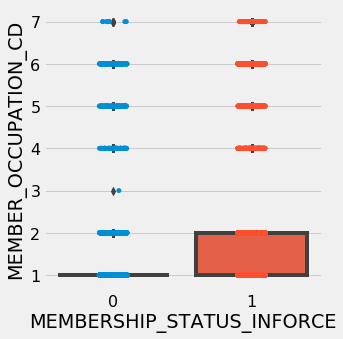

In [916]:
# Plotting the scatter plot and box plot for a few features that we got as important features from the algorithms. 

sns.catplot(x="MEMBERSHIP_STATUS_INFORCE", y="MEMBER_OCCUPATION_CD", data=onehot_req_com_data)
sns.boxplot(x="MEMBERSHIP_STATUS_INFORCE", y="MEMBER_OCCUPATION_CD", data=onehot_req_com_data)

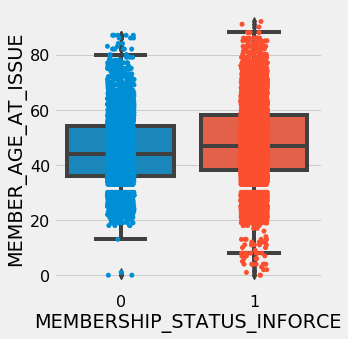

In [971]:
sns.catplot(x="MEMBERSHIP_STATUS_INFORCE", y="MEMBER_AGE_AT_ISSUE", data=onehot_req_com_data)
sns.boxplot(x="MEMBERSHIP_STATUS_INFORCE", y="MEMBER_AGE_AT_ISSUE", data=onehot_req_com_data)

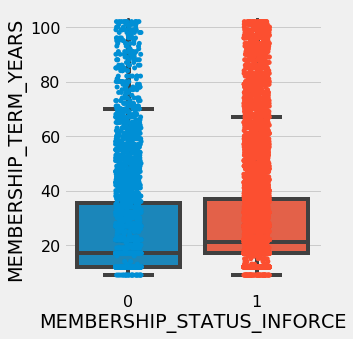

In [917]:
sns.catplot(x="MEMBERSHIP_STATUS_INFORCE", y="MEMBERSHIP_TERM_YEARS", data=onehot_req_com_data)
sns.boxplot(x="MEMBERSHIP_STATUS_INFORCE", y="MEMBERSHIP_TERM_YEARS", data=onehot_req_com_data)

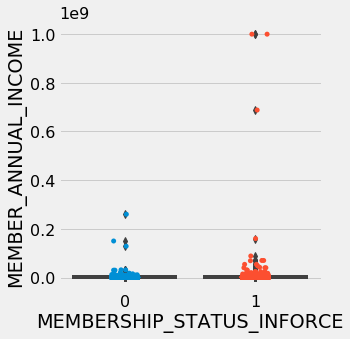

In [918]:
sns.catplot(x="MEMBERSHIP_STATUS_INFORCE", y="MEMBER_ANNUAL_INCOME", data=onehot_req_com_data)
sns.boxplot(x="MEMBERSHIP_STATUS_INFORCE", y="MEMBER_ANNUAL_INCOME", data=onehot_req_com_data)

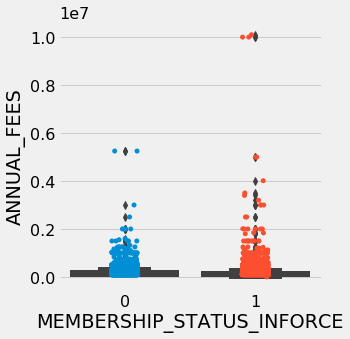

In [919]:
sns.catplot(x="MEMBERSHIP_STATUS_INFORCE", y="ANNUAL_FEES", data=onehot_req_com_data)
sns.boxplot(x="MEMBERSHIP_STATUS_INFORCE", y="ANNUAL_FEES", data=onehot_req_com_data)

### We infer from the above plots that there is too much of overlapping among the data from both the classes and hence, much can't be said about the cruciality of a feature. And this might be the reason for low accuracy of our models. 

In [921]:
# Separating data into two parts, X is independent variables (features) and y is our target variable
data_copy = onehot_req_com_data.copy()
X = onehot_req_com_data.drop(['MEMBERSHIP_STATUS_INFORCE'], axis=1)
y = onehot_req_com_data.drop(['MEMBERSHIP_TERM_YEARS', 'ANNUAL_FEES', 'MEMBER_ANNUAL_INCOME',
                        'MEMBER_OCCUPATION_CD', 'MEMBER_AGE_AT_ISSUE', 'ADDITIONAL_MEMBERS',
                        'START_DATE (YYYYMMDD)', 'MEMBER_MARITAL_STATUS_M',
                        'MEMBER_MARITAL_STATUS_Other', 'MEMBER_MARITAL_STATUS_S',
                        'MEMBER_MARITAL_STATUS_W', 'MEMBER_GENDER_M', 'MEMBER_GENDER_Other',
                        'MEMBERSHIP_PACKAGE_TYPE-B', 'PAYMENT_MODE_MONTHLY',
                        'PAYMENT_MODE_QUARTERLY', 'PAYMENT_MODE_SEMI-ANNUAL',
                        'PAYMENT_MODE_SINGLE-PREMIUM'], axis=1)

In [922]:
#apply SelectKBest class to extract top 10 best features using chi2 as score_func
bestfeatures = SelectKBest(score_func=chi2, k=5) 
fit = bestfeatures.fit(X,y.to_numpy())
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
# Printing the feature names and the scores for the top 10 
print(featureScores.nlargest(5,'Score')) 

                     Features         Score
2        MEMBER_ANNUAL_INCOME  3.063639e+08
1                 ANNUAL_FEES  3.479244e+06
4         MEMBER_AGE_AT_ISSUE  3.544417e+02
0       MEMBERSHIP_TERM_YEARS  3.127244e+02
13  MEMBERSHIP_PACKAGE_TYPE-B  1.646254e+02


In [923]:
#apply SelectKBest class to extract top 10 best features using f_classif as score_func
bestfeatures = SelectKBest(score_func=f_classif, k=5) 
fit = bestfeatures.fit(X,y.to_numpy())
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  
# Printing the feature names and the scores for the top 10 
print(featureScores.nlargest(5,'Score')) 

                       Features       Score
13    MEMBERSHIP_PACKAGE_TYPE-B  503.344248
4           MEMBER_AGE_AT_ISSUE   86.596925
3          MEMBER_OCCUPATION_CD   49.750864
9       MEMBER_MARITAL_STATUS_S   25.522295
8   MEMBER_MARITAL_STATUS_Other   24.232881


[0.15092731 0.18970041 0.23588366 0.03299403 0.24359251 0.03989813
 0.         0.0035409  0.00434327 0.00285926 0.00151296 0.0137458
 0.0033904  0.04625897 0.01224637 0.00628554 0.01234286 0.00047763]


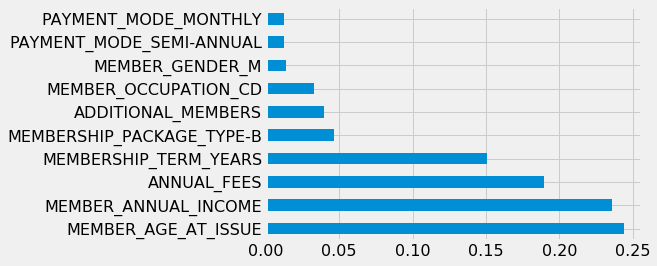

In [924]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

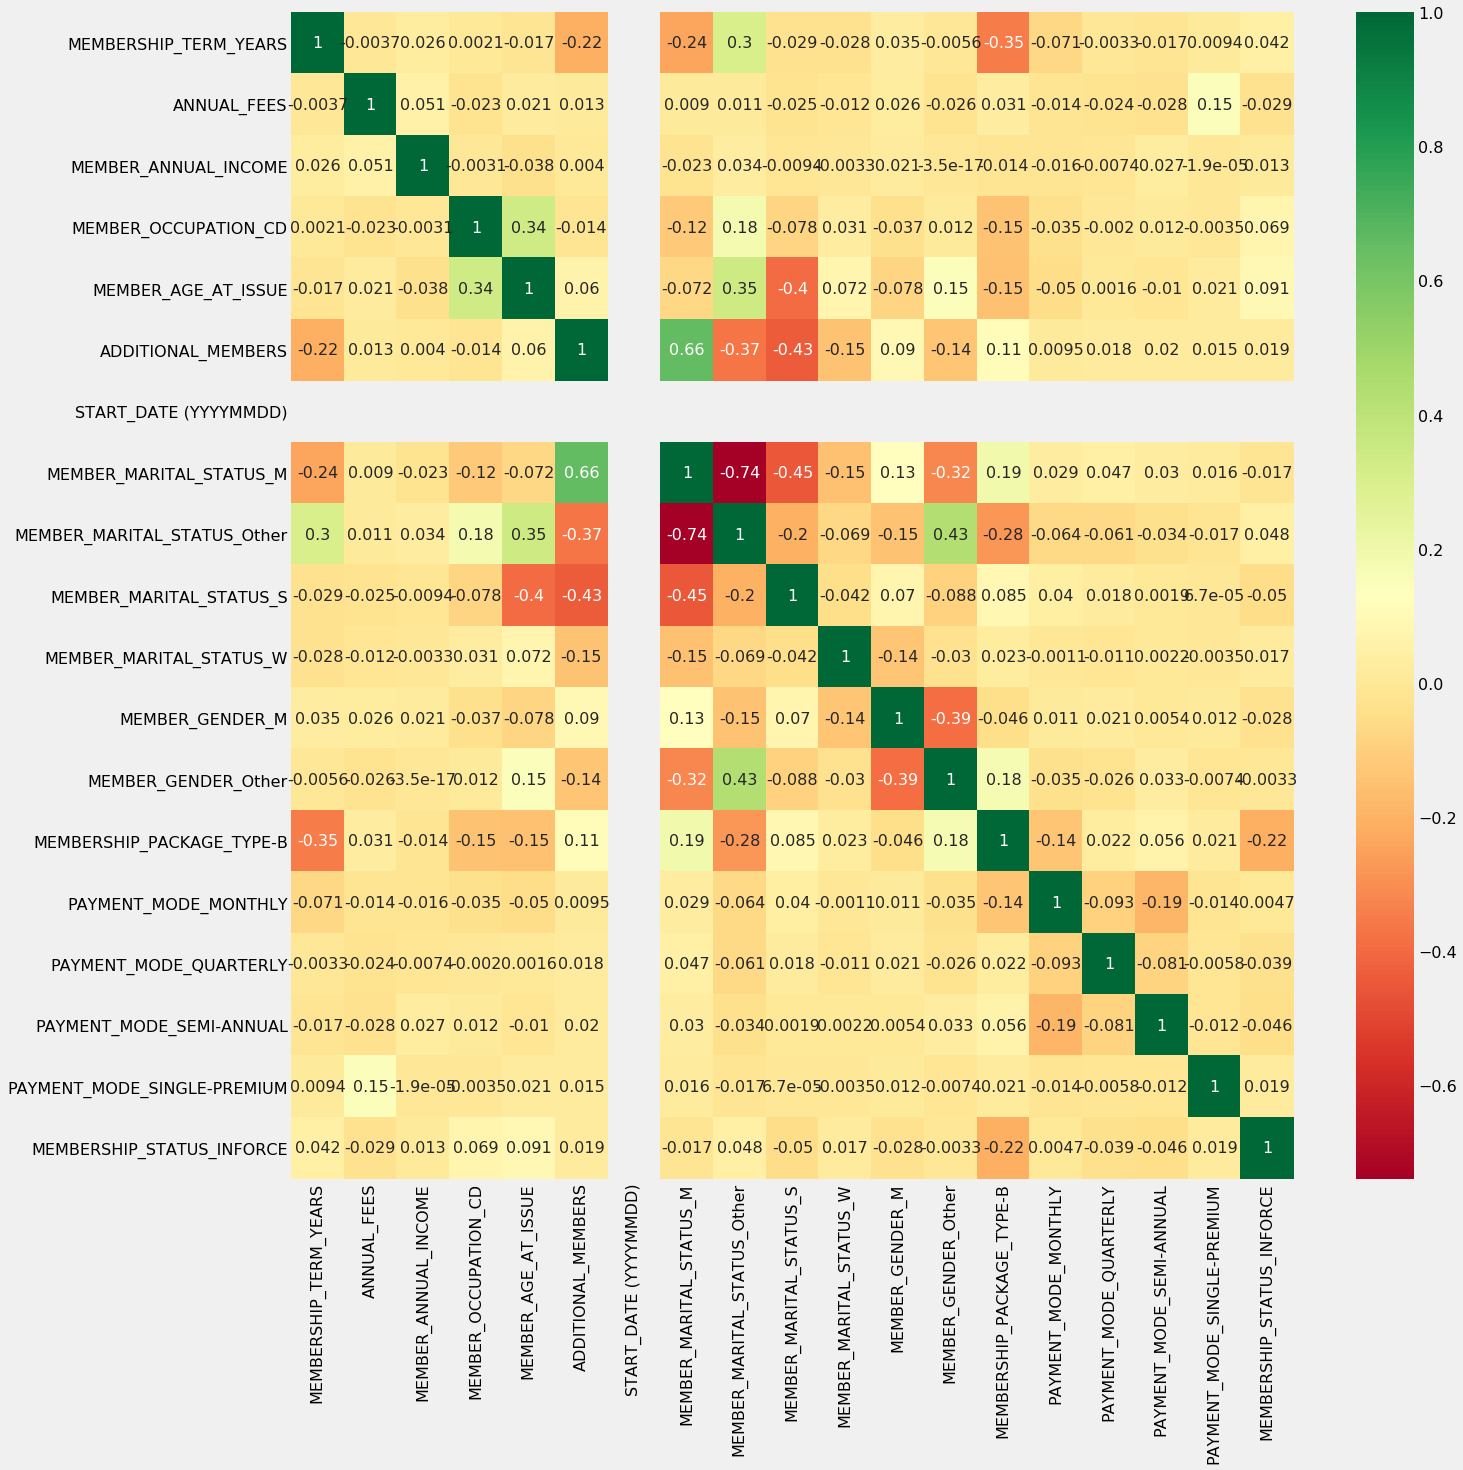

In [925]:
#get correlations of each features in dataset
corrmat = onehot_req_com_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(onehot_req_com_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Applying logistic regression and getting the coefficients

In [970]:
model = LogisticRegression(C=10**2)
ytest = ytest.to_numpy()
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.10, random_state=0, stratify=y) 
model.fit(xtrain, ytrain)
predicted_classes = model.predict(xtest)
accuracy = accuracy_score(ytest.to_numpy().flatten(), predicted_classes)
parameters = model.coef_
print("Accuracy: ", accuracy)
print("Parameters: ", parameters) # printing the coefficients 
cm = confusion_matrix(ytest, predicted_classes) 
print (cm) 

Accuracy:  0.6962391513982642
Parameters:  [[ 8.28507561e-03 -2.40994762e-07  2.54283321e-08  5.48095074e-04
   1.28839437e-02  3.84285001e-04  2.45675998e-04  1.50514080e-04
   7.63972463e-05  1.09907580e-05  5.64380138e-06  1.49593670e-04
   8.89845319e-06  1.60445836e-05  5.04529905e-05  2.98480403e-07
   1.78266792e-05  3.40997398e-07]]
[[  1 314]
 [  1 721]]


### Getting important features using Random Forrest

In [954]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(xtrain, ytrain)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100, n_jobs=None,
                                                 oob_score=False,

In [955]:
# True for the features whose importance is greater than the mean importance and False for the rest.
sel.get_support()

array([ True,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [956]:
selected_feat=xtrain.columns[(sel.get_support())]
selected_feat

Index(['MEMBERSHIP_TERM_YEARS', 'ANNUAL_FEES', 'MEMBER_ANNUAL_INCOME',
       'MEMBER_AGE_AT_ISSUE'],
      dtype='object')

In [957]:
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(xtrain, ytrain)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(xtrain, ytrain)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(xtest[xtrain.columns], ytest)))

Accuracy of XGB classifier on training set: 0.75
Accuracy of XGB classifier on test set: 0.70


In [958]:
y_pred = xgb_model.predict(xtest)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.21      0.30       315
           1       0.73      0.92      0.81       722

    accuracy                           0.70      1037
   macro avg       0.63      0.57      0.56      1037
weighted avg       0.67      0.70      0.66      1037



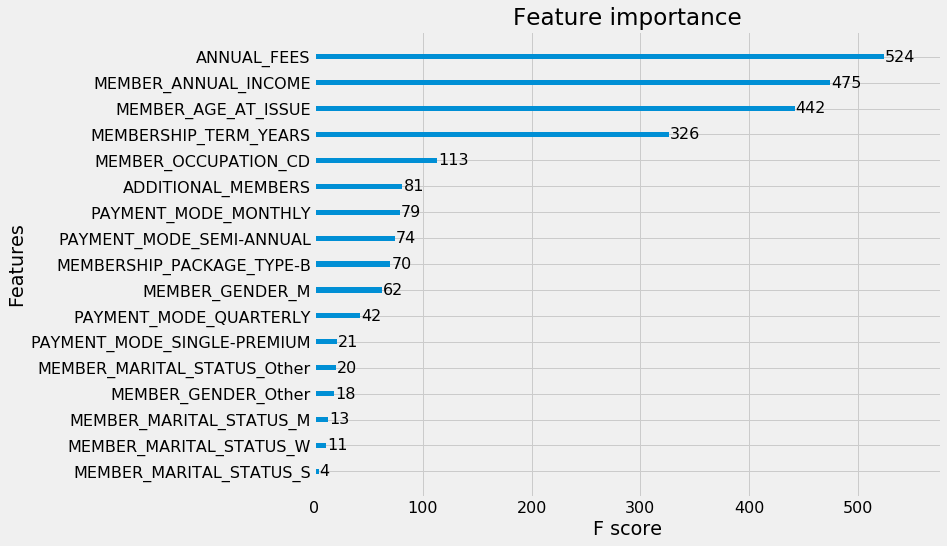

In [960]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

In [961]:
# Shows the churn probability of each user, and hence can be taken care accordingly.
data_copy['Churn_probability'] = xgb_model.predict_proba(data_copy[xtrain.columns])[:,1]
data_copy.Churn_probability[:5]

0    0.670843
1    0.825020
2    0.739480
3    0.755684
4    0.619687
Name: Churn_probability, dtype: float32

In [962]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])

# Creating parameter grid.
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
    ]
# Create grid search object
gso = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
# Fit on data

best_lrm = gso.fit(xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   57.2s finished


In [963]:
y_pred_rf = best_lrm.predict(xtest)

In [964]:
print(best_lrm.best_params_)
print(classification_report(ytest, y_pred_rf))
print(accuracy_score(ytest.to_numpy().flatten(), y_pred_rf))

{'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=11,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'classifier__max_features': 11, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.45      0.32      0.37       315
           1       0.74      0.83      0.78       722

    accuracy                           0.67      1037
   macro avg       0.59      0.57      0.58      1037
weighted avg       0.65      0.67      0.66      1037

0.6730954676952748


In [965]:
gso1 = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(gso1, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(xtrain, ytrain)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(xtest)

# New Model Evaluation metrics 
print(classification_report(ytest, y_pred_acc))

#Logistic Regression (Grid Search) Confusion matrix
print(confusion_matrix(ytest,y_pred_acc))
print(accuracy_score(ytest.to_numpy().flatten(), y_pred_acc))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       315
           1       0.70      1.00      0.82       722

    accuracy                           0.70      1037
   macro avg       0.35      0.50      0.41      1037
weighted avg       0.48      0.70      0.57      1037

[[  0 315]
 [  1 721]]
0.695274831243973
